In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [3]:
mg_noIBX_abs = pd.read_csv('/Users/turbold/Documents/CUSP/ADS/IBXRidership/mg_noIBX_abs.csv', index_col=0).fillna(0)
mg_noIBX_norm = pd.read_csv('/Users/turbold/Documents/CUSP/ADS/IBXRidership/mg_noIBX_norm.csv', index_col=0).fillna(0)
mg_noIBX_log = pd.read_csv('/Users/turbold/Documents/CUSP/ADS/IBXRidership/mg_noIBX_log.csv', index_col=0).replace([np.inf, -np.inf], np.nan).fillna(0)

In [4]:
cols_offpeak = ['cs_noibx_offpeak','lotarea', 'bldgarea',
                'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
                'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
                'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
                'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
                'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
                'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
                'vacant_homes_num', 'Bus_Stops']

cols_peak = ['cs_noibx_peak','lotarea', 'bldgarea',
             'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
             'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
             'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
             'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
             'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
             'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
             'vacant_homes_num', 'Bus_Stops']
             
mg_noIBX_abs.columns

Index(['complex_id', 'Stop Name', 'Complex_id', 'exits_weekday_evening',
       'entries_weekday_evening', 'exits_weekday_morning',
       'entries_weekday_morning', 'exits_weekday_overnight',
       'entries_weekday_overnight', 'exits_weekend_evening',
       'entries_weekend_evening', 'exits_weekend_morning',
       'entries_weekend_morning', 'exits_weekend_overnight',
       'entries_weekend_overnight', 'cs_ibx_peak', 'cs_ibx_offpeak',
       'cs_noibx_peak', 'cs_noibx_offpeak', 'VoroID', 'lotarea', 'bldgarea',
       'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
       'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
       'vacant_homes_num', 'Bus_Stops', 'geometry', 

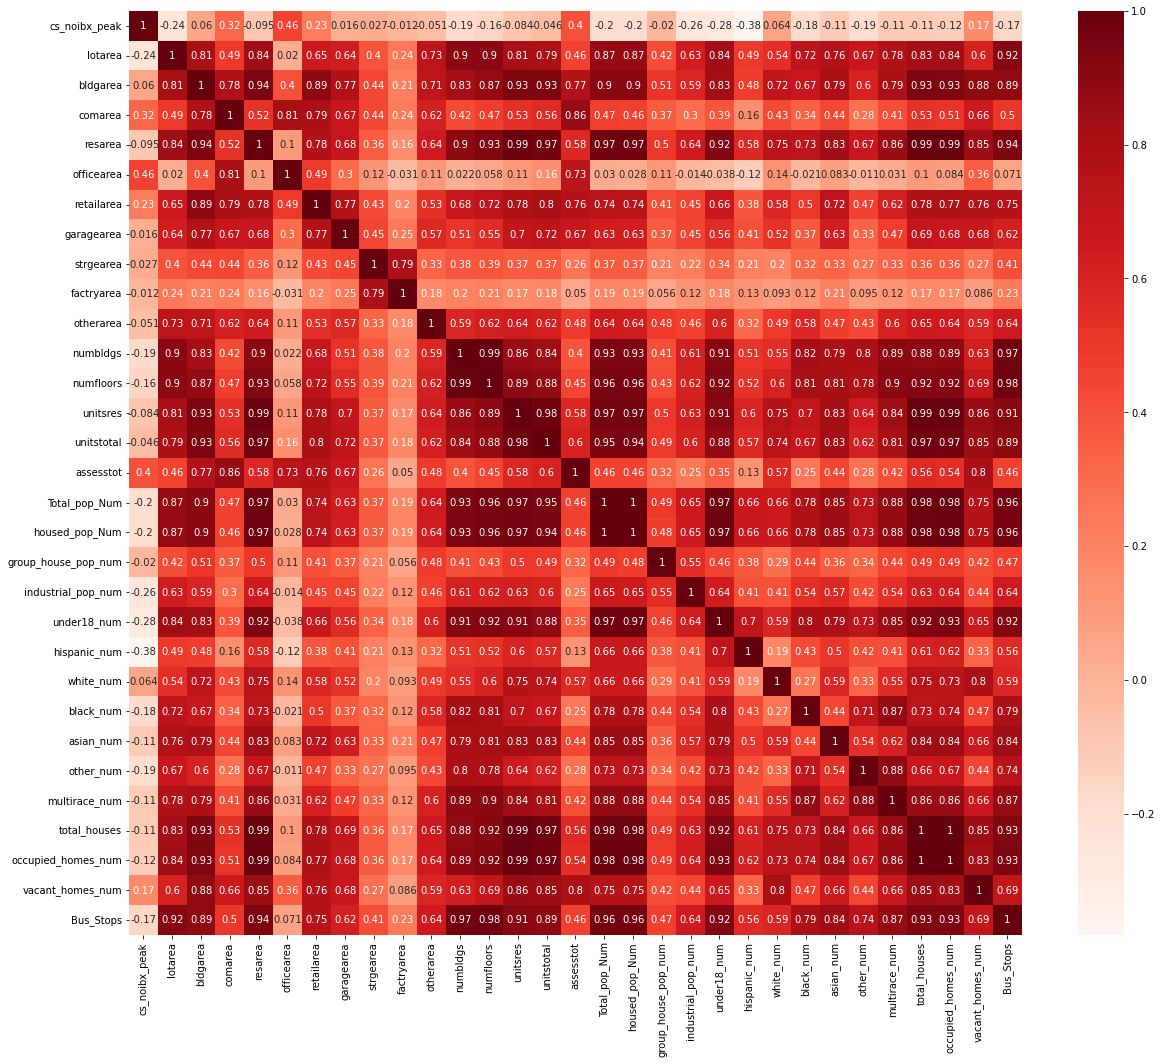

In [5]:
#Using Pearson Correlation
plt.figure(figsize=(20,17))
cor = mg_noIBX_abs[cols_peak].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [7]:
turnstile_data =['exits_weekday_evening',
       'entries_weekday_evening', 'exits_weekday_morning',
       'entries_weekday_morning', 'exits_weekday_overnight',
       'entries_weekday_overnight', 'exits_weekend_evening',
       'entries_weekend_evening', 'exits_weekend_morning',
       'entries_weekend_morning', 'exits_weekend_overnight',
       'entries_weekend_overnight']

peak_nonpeak = ['cs_noibx_peak', 'cs_noibx_offpeak']

#Simple OLS on all variables
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              model=sm.OLS(mg_noIBX_abs[commute_period],mg_noIBX_abs[cols_offpeak]).fit()  
              print('{}:'.format(commute_period), model.rsquared)
       elif 'overnight' in commute_period:
              model=sm.OLS(mg_noIBX_abs[commute_period],mg_noIBX_abs[cols_offpeak]).fit()  
              print('{}:'.format(commute_period),model.rsquared)
       else:
              model=sm.OLS(mg_noIBX_abs[commute_period],mg_noIBX_abs[cols_peak]).fit() 
              print('{}:'.format(commute_period), model.rsquared)

exits_weekday_evening: 0.6391422517285492
entries_weekday_evening: 0.7161547111591543
exits_weekday_morning: 0.7226837247439848
entries_weekday_morning: 0.6943501693880192
exits_weekday_overnight: 0.6399153086115277
entries_weekday_overnight: 0.5533396681243157
exits_weekend_evening: 0.6281433609137657
entries_weekend_evening: 0.6511150656848386
exits_weekend_morning: 0.6641448601470219
entries_weekend_morning: 0.6707783367467508
exits_weekend_overnight: 0.6134179659446968
entries_weekend_overnight: 0.5299385194004055


In [9]:
#LassoCV scores on absolute values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_abs[cols_peak], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs[cols_peak], mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))


exits_weekday_evening: 0.22494914923277776
exits_weekday_evening Selected Features: ['assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num'
 'other_num']
entries_weekday_evening: 0.4429496382558601
entries_weekday_evening Selected Features: ['lotarea' 'assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num']
exits_weekday_morning: 0.4579390796814051
exits_weekday_morning Selected Features: ['lotarea' 'assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num']
entries_weekday_morning: 0.21015790016620584
entries_weekday_morning Selected Features: ['assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num'
 'other_num']
exits_weekday_overnight: 0.22447645624729673
exits_weekday_overnight Selected Features: ['lotarea' 'bldgarea' 'assesstot' 'occupied_homes_num' 'total_houses']
entries_weekday_overnight: 0.2230433109081923
entries_weekday_overnight Selected Features: ['assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num'
 'other_num']
exits_weekend_eveni

In [10]:
#LassoCV scores on log values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))

exits_weekday_evening: 0.41866815959007264
exits_weekday_evening Selected Features: ['resarea' 'occupied_homes_num' 'unitstotal' 'numfloors' 'numbldgs']
entries_weekday_evening: 0.637758094796826
entries_weekday_evening Selected Features: ['assesstot' 'lotarea' 'retailarea' 'Bus_Stops' 'numbldgs']
exits_weekday_morning: 0.5845377685164707
exits_weekday_morning Selected Features: ['assesstot' 'lotarea' 'Bus_Stops' 'retailarea' 'unitstotal']
entries_weekday_morning: 0.4892260554583785
entries_weekday_morning Selected Features: ['resarea' 'occupied_homes_num' 'total_houses' 'unitstotal' 'numbldgs']
exits_weekday_overnight: 0.42321388745819855
exits_weekday_overnight Selected Features: ['resarea' 'numfloors' 'numbldgs' 'lotarea' 'Bus_Stops']
entries_weekday_overnight: 0.4862974536597705
entries_weekday_overnight Selected Features: ['assesstot' 'retailarea' 'white_num' 'Bus_Stops' 'lotarea']
exits_weekend_evening: 0.512103790318198
exits_weekend_evening Selected Features: ['resarea' 'assess

In [11]:
#LassoCV scores on norm values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_norm[cols_peak], mg_noIBX_norm[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_norm[cols_peak], mg_noIBX_norm[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))

exits_weekday_evening: 0.16583954241927457
exits_weekday_evening Selected Features: ['assesstot' 'Bus_Stops' 'bldgarea' 'occupied_homes_num' 'total_houses']
entries_weekday_evening: 0.37390638563580814
entries_weekday_evening Selected Features: ['assesstot' 'Bus_Stops' 'bldgarea' 'occupied_homes_num' 'total_houses']
exits_weekday_morning: 0.36744229724848576
exits_weekday_morning Selected Features: ['assesstot' 'Bus_Stops' 'bldgarea' 'occupied_homes_num' 'total_houses']
entries_weekday_morning: 0.14820306404768646
entries_weekday_morning Selected Features: ['Bus_Stops' 'assesstot' 'bldgarea' 'occupied_homes_num' 'total_houses']
exits_weekday_overnight: 0.12857621808988406
exits_weekday_overnight Selected Features: ['assesstot' 'Bus_Stops' 'bldgarea' 'occupied_homes_num' 'total_houses']
entries_weekday_overnight: 0.1906969334308395
entries_weekday_overnight Selected Features: ['Bus_Stops' 'assesstot' 'bldgarea' 'occupied_homes_num' 'total_houses']
exits_weekend_evening: 0.20595463215445

In [14]:
# make a pipeline - specify the model
pipe = Pipeline([("scale", preprocessing.StandardScaler()),
                 ("reduce_dims", PCA()),
                 ("lasso", Lasso())
                ])

param_grid = dict(reduce_dims__n_components = np.arange(1,31,1),
                  lasso__alpha = 2.0**(np.arange(-10, 10, 1)))

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True,n_jobs=-1, cv=5)



#Loop through different independent variables                  
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              grid.fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       elif 'overnight' in commute_period:
              grid.fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       else:
              grid.fit(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
exits_weekday_evening best R-score: 0.2991562556877284
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=15)),
                ('lasso', Lasso(alpha=0.00390625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
entries_weekday_evening best R-score: 0.5518947962083067
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=17)),
                ('lasso', Lasso(alpha=0.0078125))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
exits_weekday_morning best R-score: 0.4775006666129542
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=15)),
                ('lasso', Lasso(alpha=0.00390625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
entries_weekday_morning best R-score: 0.3092764943964072
Pipeline(steps=[('scale', StandardScaler()),
                (

In [52]:
grid.best_params_

{'lasso__alpha': 32.0, 'reduce_dims__n_components': 17}